# Audio key estimation of digital music with CNNs
Udacity Machine Learning Nanodegree - Capstone project

---

## Table of Contents

The project is structured as stated in section 'Project Design' of the Capstone project proposal.

_
<pre>
<a href='#Data-Preprocessing'>Data Preprocessing</a>
  <a href='#Million-Song-Dataset'>Million Song Dataset</a> - selection of appropriate songs, separate jupyter notebook
  <a href='#Signal-Processing-and-Feature-Extraction'>Signal Processing and Feature Extraction</a> - separate jupyter notebook

<a href='#Model-Preparation'>Model Preparation</a>
  <a href='#Load-and-preprocess-data'>Load and preprocess data</a> - read spectrogram images, conversion to tensors
  <a href='#Split-data-into-train-and-test-set'>Splitting data into training/testing sets</a>
  <a href='#Model-architecture'>CNN model architecture</a>
  <a href='#Model-parameter'>CNN model parameter</a>

<a href='#Model-Training-and-Evaluation'>Model Training and Evaluation</a>
  <a href='#Model-training'>Model training</a>
  <a href='#Model-evaluation-and-comparison'>Model evaluation and comparison</a>
</pre>

Current version of the project is working, but

the project is still ongoing...

discussion and remarks of what to do can be found in section

<a href='#reasons-/-todo'>reasons / todo</a>

## Data Preprocessing
---

### Million Song Dataset
- utilized to select appropriate song samples
- holds information about key and mode per song (targets)

Juypter Notebook <a href='./00.hlp/msd/msd.ipynb'>msd</a>

outputs: csv file *songs_conf=75_tracks_filt.csv*, which holds all songs with key confidence and mode confidence > 0.75

In [1]:
# LIST SELECTED SONGS
import os
import pandas as pd
from IPython.display import display

selsongsfile = os.path.join ('00.hlp', 'msd', 'songs_conf=75_tracks_filt.csv')
selsongs = pd.read_csv (selsongsfile, header=0, index_col=0)
display (selsongs.head (1))
print ('[i] number of records:', len (selsongs))

,key,key_confidence,mode,mode_confidence,tempo,track_id,song_id,artist_name,song_title
0,7,0.896,1,0.852,114.493,TRMMMGL128F92FD6AB,SOHSSPG12A8C144BE0,Clifford T. Ward,Mad About You


[i] number of records: 47913


In [2]:
# LOAD AUDIO DATASET
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_audio')
load_content = False
description = ['Cm', 'C', 'C#m', 'C#',
               'Dm', 'D', 'D#m', 'D#',
               'Em', 'E',
               'Fm', 'F', 'F#m', 'F#',
               'Gm', 'G', 'G#m', 'G#',
               'Am', 'A', 'A#m', 'A#',
               'Bm', 'B']

src_audio_data = datasets.load_files (container_path=container_path,
                                      description=description,
                                      load_content=load_content,
                                      random_state=PARAM_RND_STATE)

In [3]:
# FYI: LIST SOME OF THE USED SONGS
filenames = list (os.path.basename (filepath) for filepath in src_audio_data['filenames'])
usedsongs_track_id = list (os.path.splitext (fn)[0] for fn in filenames)
usedsongs = selsongs.query ('track_id in @usedsongs_track_id')

display (usedsongs.sample(5))
print ('[i] number of records:', len (usedsongs))
print ('[i] min of: key_confidence =', usedsongs['key_confidence'].min (), ',', \
       'mode_confidence =', usedsongs['mode_confidence'].min ())
print ('[i] tempo: min =', usedsongs['tempo'].min (), ',', \
       'max =', usedsongs['tempo'].max ())

,key,key_confidence,mode,mode_confidence,tempo,track_id,song_id,artist_name,song_title
311,7,1.0,1,1.000,178.571,TRMCBGQ128F425C0A8,SOHGQTL12A8C139348,Jo-El Sonnier,The Back Door
29273,0,1.0,0,0.889,132.947,TRUXMRH128F92F7A43,SOGTREL12AB0181DC8,Blues Company,Dark Day
21568,3,1.0,0,0.847,153.823,TRAVHZZ128F424BEDA,SONSGIT12A8C138856,Heldon,In Wake of King Fripp
46577,11,1.0,1,0.965,95.543,TRYFBHO128F422B190,SONEEWO12A58A7F42A,Tom Rush,Rockport Sunday [Remastered Album Version]
10322,1,1.0,1,1.000,101.146,TRRJCHZ128F4270606,SOANZZR12A8C134DE5,Vivian Khor,Ancient Wanderer


[i] number of records: 312
[i] min of: key_confidence = 0.825 , mode_confidence = 0.777
[i] tempo: min = 0.0 , max = 248.32299999999998


In [4]:
# ----- save list of used songs
usedsongs.to_csv ('usedsongs.csv')

In [5]:
# ----- save list of unused songs
unusedsongs = selsongs.drop ((usedsongs.index.values))
unusedsongs.to_csv ('unusedsongs.csv')

### Signal Processing and Feature Extraction
- create spectrograms of audio files with discrete Fourier transform (DFT)
- save spectrograms as images for further use in CNN

Juypter Notebook <a href='./00.hlp/fft/fft.ipynb'>fft</a>

ouptuts: spectrograms (png images) of audio files with same folder structure as *src_audio* in new container path named *src_spectro*

**Example of a spectrogram image**

<img src ='./src_spectro/7-0/TREDRTV12903D03829.png' align=left>

## Model Preparation
---

### Load and preprocess data

### Data Preprocessing
Since there aren't enough samples to proper train the classifier, image augmentation is used.

Below jupyter notebook does the work.

Juypter Notebook <a href='./00.hlp/trnsp/trnsp.ipynb'>transposing songs</a>

In [126]:
# LOAD SPECTROGRAM FILENAMES
import os
import numpy as np
from sklearn import datasets

PARAM_RND_STATE = 42

container_path = os.path.join ('src_spectro')
load_content = False

src_spectro_data = datasets.load_files (container_path=container_path,
                                        load_content=load_content,
                                        random_state=PARAM_RND_STATE)
src_spectro_data.keys ()

dict_keys(['DESCR', 'target_names', 'filenames', 'target'])

**Read in images, convert to tensors**

Keras Conv2D layers expect a **4D tensor with shape (batch, rows, cols, channels)** (if param data_format='channels_last') (src: <a href='https://keras.io/layers/convolutional/#conv2d'>Keras Conv2D</a>)

In [127]:
import numpy as np
import pandas as pd

src_spectro_data_pd = pd.DataFrame (
    np.column_stack ((src_spectro_data['filenames'], src_spectro_data['target'])),
    columns=['filenames', 'target'])

src_spectro_data_pd = src_spectro_data_pd.sample (frac=1, random_state=PARAM_RND_STATE).reset_index (drop=True)

src_spectro_data_pd.head (5)

,filenames,target
0,src_spectro/3-0/TRJFGEL128F4265C5F.png,10
1,src_spectro/4-0/TROEPPK128F92F33EC.png,12
2,src_spectro/1-1/TRCORZL128F4281888_0-oct.png,3
3,src_spectro/5-0/TRCAQKL12903CB7415_0-oct.png,14
4,src_spectro/7-0/TREPPRE128F148D1F0.png,18


In [128]:
# open a random image and take a look at the attributes
import numpy as np
from PIL import Image

im = Image.open (src_spectro_data_pd['filenames'][0])
print ('[i] image size:', im.size)
print ('[i] pixel format:', im.mode)

[i] image size: (150, 128)
[i] pixel format: RGB


**Changing target size of image**

CNNs work best if input size is divisible by 2 many times - image size needs to be changed. (<a href='http://cs231n.github.io/convolutional-networks/#layersizepat'>cs231n - Layer Sizing Patterns</a>)

Current image size is 150 x 128: possible options
- (-) cut down the image to 128 x 128: information loss in song length
- (-) resize to 150 x 150: not divisible by 2 many times (exactly 1 time)
- (+) resize to 160 x 160: divisible by 2 many times (exactly 5 times, this is enough)

Resizing is done by appending zeros.

In [129]:
import numpy as np

PARAM_TARGET_SIZE = 160
def resize_image (img_arr):
    #print ('>>> resizing image to [{}, {}]...'.format (PARAM_IMG_SIZE, PARAM_IMG_SIZE), end=' ', flush=True)
    
    m = img_arr.shape[0]
    n = img_arr.shape[1]
    
    # how many additional cols to add?
    cols_to_add = PARAM_TARGET_SIZE - n
    
    img_resized = np.empty ((1, PARAM_TARGET_SIZE))
    for i in range (m):
        new_line = np.append (img_arr[i], np.zeros (cols_to_add))
        img_resized = np.vstack ((img_resized, new_line))
    
    img_resized = img_resized[1:]
    # now img_resized = (128, 160)
    
    # how many additional rows to add?
    rows_to_add = PARAM_TARGET_SIZE - m
    img_resized = np.vstack ((img_resized, np.zeros ((rows_to_add, PARAM_TARGET_SIZE))))
    # now img_resize = (160, 160)
    
    #print ('done')
    
    return img_resized

**Feature scaling by feature standardization**

$x^{'}= \frac{x-\bar{x}}{\sigma}$

tensorflow function used to do this

Below functions read the images and convert those to tensors - original code taken from Udacity MLND dog-project

In [130]:
from keras.preprocessing import image
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm

PARAM_USE_IMG_STD = True

def path_to_tensor (img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img (img_path, color_mode='grayscale')
    
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array (img)
    x = resize_image (x)
    x = x[:,:,np.newaxis]
    
    # feature standardization to zero mean and stdev of one
    # [2018-09-04] turned out that standardization prevents good learning progress
    # [2018-09-06] try again with standardization
    if PARAM_USE_IMG_STD:
        x = K.eval (tf.image.per_image_standardization (x))
    
    # convert 3D tensor to 4D tensor
    return np.expand_dims (x, axis=0)

def paths_to_tensor (img_paths):
    list_of_tensors = [path_to_tensor (img_path) for img_path in tqdm (img_paths)]
    return np.vstack (list_of_tensors)

In [131]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

spectro_tensors = paths_to_tensor (src_spectro_data_pd['filenames'])

print ('[i] shape of spectrogram tensors:', spectro_tensors.shape)

100%|██████████| 936/936 [02:28<00:00,  6.30it/s]

[i] shape of spectrogram tensors: (936, 160, 160, 1)


In [132]:
from keras.utils import np_utils
targets = np_utils.to_categorical (np.array (src_spectro_data_pd['target']), 24)
print ('[i] number of output classes:', targets.shape[1])

[i] number of output classes: 24


### Split data into train and test set
[2018-09-03] obsolete since test data is in separate directory now

In [133]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = \
#    train_test_split (spectro_tensors, targets, test_size=(8/39), shuffle=True, random_state=PARAM_RND_STATE)

#print ('[i] Training dataset consists of {} samples'.format (X_train.shape[0]))
#print ('[i] Testing dataset consists of {} samples'.format (X_test.shape[0]))

X_train = spectro_tensors
y_train = targets
print ('[i] Training dataset consists of {} samples'.format (X_train.shape[0]))

[i] Training dataset consists of 936 samples


### Model architecture

(<a href='http://cs231n.github.io/convolutional-networks/#layersizepat'>cs231n - Layer Sizing Patterns</a>)

In [134]:
from keras import layers, models, regularizers
from keras import backend as K

# clear everything known of past instances ("useful to avoid clutter from old models / layers")
K.clear_session ()

# input layer
inputs = layers.Input (shape=spectro_tensors.shape[1:], name='input')

# hidden layers
net = layers.Conv2D (filters=128, kernel_size=(2,2), strides=(1,1),
                     padding='same',
                     activation='relu',
                     name='fex.conv2d_1') (inputs)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='fex.maxp_1') (net)

net = layers.Conv2D (filters=128, kernel_size=(2,2), strides=(1,1),
                     padding='same',
                     activation='relu',
                     name='fex.conv2d_2') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='fex.maxp_2') (net)

net = layers.Conv2D (filters=256, kernel_size=(2,2), strides=(1,1),
                     padding='same',
                     activation='relu',
                     name='fex.conv2d_3') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='fex.maxp_3') (net)

net = layers.Conv2D (filters=256, kernel_size=(2,2), strides=(1,1),
                     padding='same',
                     activation='relu',
                     name='fex.conv2d_4') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='fex.maxp_4') (net)

net = layers.Conv2D (filters=512, kernel_size=(2,2), strides=(1,1),
                     padding='same',
                     activation='relu',
                     name='fex.conv2d_5') (net)
net = layers.MaxPooling2D (pool_size=(2,2), strides=None, name='fex.maxp_5') (net)

# 'flatten layer'
net = layers.GlobalAveragePooling2D (name='fex.avg_flat') (net)

#net = layers.Flatten (name='cls.flat_1') (net)

net = layers.Dense (units=1024, activation='relu', name='cls.fc_1') (net)

#net = layers.Dropout (0.25, seed=PARAM_RND_STATE, name='reg.drop_1') (net)

net = layers.Dense (units=512, activation='relu', name='cls.fc_2') (net)

net = layers.Dense (units=512, activation='relu', name='cls.fc_3') (net)

net = layers.Dense (units=256, activation='relu', name='cls.fc_4') (net)

# output layer
outputs = layers.Dense (units=targets.shape[1], activation='softmax', name='output') (net)


model = models.Model (inputs=inputs, outputs=outputs)
model.summary ()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 1)       0         
_________________________________________________________________
fex.conv2d_1 (Conv2D)        (None, 160, 160, 128)     640       
_________________________________________________________________
fex.maxp_1 (MaxPooling2D)    (None, 80, 80, 128)       0         
_________________________________________________________________
fex.conv2d_2 (Conv2D)        (None, 80, 80, 128)       65664     
_________________________________________________________________
fex.maxp_2 (MaxPooling2D)    (None, 40, 40, 128)       0         
_________________________________________________________________
fex.conv2d_3 (Conv2D)        (None, 40, 40, 256)       131328    
_________________________________________________________________
fex.maxp_3 (MaxPooling2D)    (None, 20, 20, 256)       0         
__________

### Model parameter
(metric, loss function)

In [135]:
# from: Arseny Kravchenko http://arseny.info/2017/f-beta-score-for-keras.html
from keras import backend as K

PARAM_BETA = 1
def fbeta (y_true, y_pred):

    # just in case of hipster activation at the final layer
    y_pred = K.clip (y_pred, 0, 1)

    tp = K.sum (K.round (y_true * y_pred)) + K.epsilon ()
    fp = K.sum (K.round (K.clip (y_pred - y_true, 0, 1)))
    fn = K.sum (K.round (K.clip (y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = PARAM_BETA ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall)

In [138]:
from keras import optimizers, losses

PARAM_LR = 0.015 #initial start value for est opt lr: 0.0001
PARAM_MOM = 0.9
PARAM_LRDEC = PARAM_LR*0.01
opt = optimizers.SGD (lr=PARAM_LR, momentum=PARAM_MOM, decay=PARAM_LRDEC)

loss = losses.categorical_crossentropy

model.compile (optimizer=opt, loss=loss, metrics=[fbeta])

## Model Training and Evaluation
---

### Model training

#### new model

In [139]:
from sklearn.model_selection import train_test_split
from keras import backend as K
import math
import numpy as np
import time


PARAM_VAL_SPLIT = 6/39 #2/10 #6/39
# set some training data apart for validation
X_tr, X_val, y_tr, y_val = \
    train_test_split (X_train, y_train, test_size=PARAM_VAL_SPLIT, shuffle=False, random_state=PARAM_RND_STATE)

print ('training set: features {}, targets {}'.format (X_tr.shape, y_tr.shape))
print ('validation set: features {}, targets {}'.format (X_val.shape, y_val.shape))
scalars_train, scalars_val = [], []

# batch run
PARAM_N_BATCH = 24
max_batches = X_tr.shape[0] // PARAM_N_BATCH
last_batch = X_tr.shape[0] % PARAM_N_BATCH

# training
PARAM_MAX_EPOCHS = 200

# learning rate changer
LR_MAX = 1.5
scalars_lr = \
    np.exp (np.arange (
        math.log (PARAM_LR), math.log (LR_MAX), (math.log (LR_MAX) - math.log (PARAM_LR))/PARAM_MAX_EPOCHS))


epoch = 1
while (epoch <= PARAM_MAX_EPOCHS):
    
    start_time = time.time ()
    
    print ('epoch {}:'.format (epoch))
    
    for i in range (max_batches):
        # training
        print ('\r', (i+1)*PARAM_N_BATCH, '/', X_tr.shape[0], end=', ')
        ret = model.train_on_batch (
            X_tr[i*PARAM_N_BATCH:(i+1)*PARAM_N_BATCH], y_tr[i*PARAM_N_BATCH:(i+1)*PARAM_N_BATCH])
        
        # validation
        val = model.test_on_batch (X_val, y_val)
    
    if (last_batch > 0):
        # training
        print ('\r', max_batches * PARAM_N_BATCH + last_batch, '/', X_tr.shape[0], end=', ')
        ret = model.train_on_batch (X_tr[-last_batch:], y_tr[-last_batch:])
        
        # validation
        val = model.test_on_batch (X_val, y_val)
    
    # print results
    print (model.metrics_names[0], ret[0], end=' ')
    print (model.metrics_names[1], ret[1], end=', ')
    print ('val', model.metrics_names[0], val[0],'val', model.metrics_names[1], val[1])
    
    # learning rate update
    #current_lr = K.get_value (model.optimizer.lr)
    #print ('current lr:', current_lr)
    #new_lr = scalars_lr[epoch-1]
    #K.set_value (model.optimizer.lr, new_lr)
    #print ('new lr:', new_lr)
    
    scalars_train.append (ret)
    scalars_val.append (val)
    
    epoch += 1
    
    end_time = time.time () - start_time
    print ('[i] time taken for last epoch: {:.2f} s'.format (end_time))
    print ('[i] estimation for remaining epochs: {:.2f} s'.format (end_time * (PARAM_MAX_EPOCHS-epoch+1)))

training set: features (792, 160, 160, 1), targets (792, 24)
validation set: features (144, 160, 160, 1), targets (144, 24)
epoch 1:
 792 / 792, loss 3.1923618 fbeta 8.333333e-09, val loss 3.1903489 val fbeta 1.3888889e-09
[i] time taken for last epoch: 410.43 s
[i] estimation for remaining epochs: 81675.03 s
epoch 2:
 792 / 792, loss 3.1807613 fbeta 8.333333e-09, val loss 3.1971622 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.56 s
[i] estimation for remaining epochs: 81093.52 s
epoch 3:
 792 / 792, loss 3.1710236 fbeta 8.333333e-09, val loss 3.1999648 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.22 s
[i] estimation for remaining epochs: 80617.25 s
epoch 4:
 792 / 792, loss 3.1711934 fbeta 8.333333e-09, val loss 3.201575 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.15 s
[i] estimation for remaining epochs: 80193.28 s
epoch 5:
 792 / 792, loss 3.1700318 fbeta 8.333333e-09, val loss 3.2022538 val fbeta 1.3888889e-09
[i] time taken for last epoch:

 792 / 792, loss 1.6729532 fbeta 0.28571427, val loss 2.9419978 val fbeta 0.1875
[i] time taken for last epoch: 409.46 s
[i] estimation for remaining epochs: 63465.83 s
epoch 46:
 792 / 792, loss 1.6667622 fbeta 0.3783784, val loss 3.0112936 val fbeta 0.23214287
[i] time taken for last epoch: 409.45 s
[i] estimation for remaining epochs: 63054.56 s
epoch 47:
 792 / 792, loss 2.1515977 fbeta 0.25, val loss 3.056831 val fbeta 0.18090452
[i] time taken for last epoch: 409.96 s
[i] estimation for remaining epochs: 62724.35 s
epoch 48:
 792 / 792, loss 1.669478 fbeta 0.36363637, val loss 2.7399786 val fbeta 0.28571427
[i] time taken for last epoch: 409.46 s
[i] estimation for remaining epochs: 62238.38 s
epoch 49:
 792 / 792, loss 1.6368971 fbeta 0.42424244, val loss 3.2441428 val fbeta 0.20192309
[i] time taken for last epoch: 412.39 s
[i] estimation for remaining epochs: 62271.27 s
epoch 50:
 792 / 792, loss 2.1795237 fbeta 0.25641027, val loss 2.867567 val fbeta 0.17560975
[i] time taken

 792 / 792, loss 0.8514001 fbeta 0.79069763, val loss 2.5846992 val fbeta 0.497992
[i] time taken for last epoch: 408.93 s
[i] estimation for remaining epochs: 44573.02 s
epoch 92:
 792 / 792, loss 0.63620293 fbeta 0.84444445, val loss 2.5081015 val fbeta 0.45217392
[i] time taken for last epoch: 409.00 s
[i] estimation for remaining epochs: 44171.80 s
epoch 93:
 792 / 792, loss 1.228633 fbeta 0.65, val loss 2.9992 val fbeta 0.39473683
[i] time taken for last epoch: 409.04 s
[i] estimation for remaining epochs: 43767.28 s
epoch 94:
 792 / 792, loss 0.6459188 fbeta 0.81818175, val loss 3.5187879 val fbeta 0.37656906
[i] time taken for last epoch: 409.29 s
[i] estimation for remaining epochs: 43384.51 s
epoch 95:
 792 / 792, loss 1.1719828 fbeta 0.7111111, val loss 2.6093423 val fbeta 0.42342344
[i] time taken for last epoch: 408.92 s
[i] estimation for remaining epochs: 42936.37 s
epoch 96:
 792 / 792, loss 1.5679699 fbeta 0.72727275, val loss 3.2616658 val fbeta 0.40322578
[i] time tak

 792 / 792, loss 3.1615055 fbeta 8.333333e-09, val loss 3.2062376 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.00 s
[i] estimation for remaining epochs: 26175.97 s
epoch 137:
 792 / 792, loss 3.1610706 fbeta 8.333333e-09, val loss 3.2065697 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.23 s
[i] estimation for remaining epochs: 25781.52 s
epoch 138:
 792 / 792, loss 3.1607006 fbeta 8.333333e-09, val loss 3.2068746 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.10 s
[i] estimation for remaining epochs: 25364.31 s
epoch 139:
 792 / 792, loss 3.1603844 fbeta 8.333333e-09, val loss 3.2071528 val fbeta 1.3888889e-09
[i] time taken for last epoch: 408.96 s
[i] estimation for remaining epochs: 24946.61 s
epoch 140:
 792 / 792, loss 3.1601126 fbeta 8.333333e-09, val loss 3.2074056 val fbeta 1.3888889e-09
[i] time taken for last epoch: 408.94 s
[i] estimation for remaining epochs: 24536.50 s
epoch 141:
 792 / 792, loss 3.159878 fbeta 8.333333e-09, val loss 

 792 / 792, loss 3.1580238 fbeta 8.333333e-09, val loss 3.2096186 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.16 s
[i] estimation for remaining epochs: 8183.27 s
epoch 181:
 792 / 792, loss 3.1580162 fbeta 8.333333e-09, val loss 3.2096224 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.19 s
[i] estimation for remaining epochs: 7774.59 s
epoch 182:
 792 / 792, loss 3.1580093 fbeta 8.333333e-09, val loss 3.2096257 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.36 s
[i] estimation for remaining epochs: 7368.44 s
epoch 183:
 792 / 792, loss 3.1580021 fbeta 8.333333e-09, val loss 3.2096288 val fbeta 1.3888889e-09
[i] time taken for last epoch: 408.70 s
[i] estimation for remaining epochs: 6947.97 s
epoch 184:
 792 / 792, loss 3.157995 fbeta 8.333333e-09, val loss 3.2096314 val fbeta 1.3888889e-09
[i] time taken for last epoch: 409.29 s
[i] estimation for remaining epochs: 6548.66 s
epoch 185:
 792 / 792, loss 3.1579878 fbeta 8.333333e-09, val loss 3.209

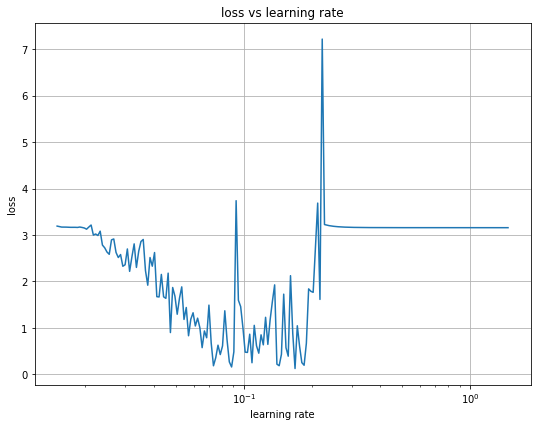

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots (1, 1)

df_train = pd.DataFrame (scalars_train, columns=model.metrics_names)
axs.plot (scalars_lr, df_train['loss'])
axs.set (ylabel='loss', xlabel='learning rate', title='loss vs learning rate')
axs.set_xscale ('log')
axs.grid ()

fig.set_size_inches (640/fig.dpi, 480/fig.dpi)

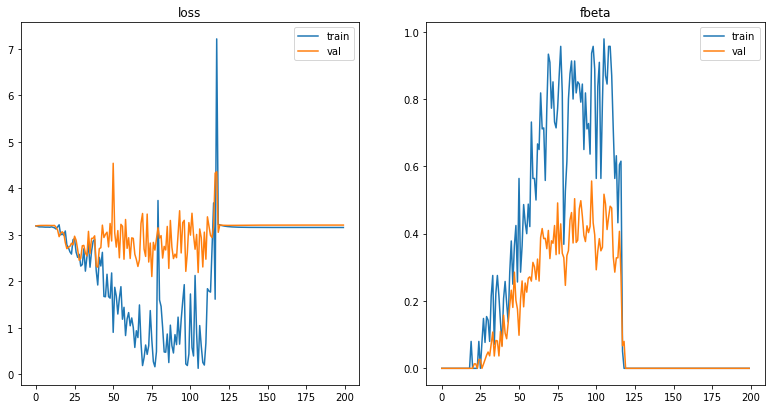

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

df_train = pd.DataFrame (scalars_train, columns=model.metrics_names)
df_val = pd.DataFrame (scalars_val, columns=model.metrics_names)

fig, axs = plt.subplots (1, 2)

axs[0].set_title (model.metrics_names[0])
axs[0].plot (df_train[model.metrics_names[0]])
axs[0].plot (df_val[model.metrics_names[0]])
axs[0].legend (['train', 'val'])

axs[1].set_title (model.metrics_names[1])
axs[1].plot (df_train[model.metrics_names[1]])
axs[1].plot (df_val[model.metrics_names[1]])
axs[1].legend (['train', 'val'])

fig.set_size_inches (480*2/fig.dpi, 480/fig.dpi)

#### old model

In [14]:
import os
from keras import callbacks

PARAM_MAX_EPOCHS = 200 #500 # PARAM: number of model-fit runs
PARAM_N_BATCH = 44 #22 #62 #64 # PARAM: number of input samples for one feedfwd-backprop step
PARAM_VAL_SPLIT = 6/39 #4/39

checkpointer = callbacks.ModelCheckpoint (
    filepath=os.path.join ('model','model.w.best.h5'),
    verbose=1,
    save_best_only=True)

#earlystop = callbacks.EarlyStopping (
#    monitor='val_loss', min_delta=0.001, patience=15,
#    verbose=0, mode='auto', baseline=None)

history = model.fit (X_train, y_train,
                     epochs=PARAM_MAX_EPOCHS, batch_size=PARAM_N_BATCH, validation_split=PARAM_VAL_SPLIT,
                     shuffle=True, callbacks=[checkpointer], verbose=1)

Train on 792 samples, validate on 144 samples
Epoch 1/200
 88/792 [==>...........................] - ETA: 59s - loss: 3.1779 - fbeta: 4.5455e-09 

KeyboardInterrupt: 

### Model evaluation and comparison

In [33]:
print (history.history.keys())

dict_keys(['val_fbeta', 'fbeta', 'loss', 'val_loss'])


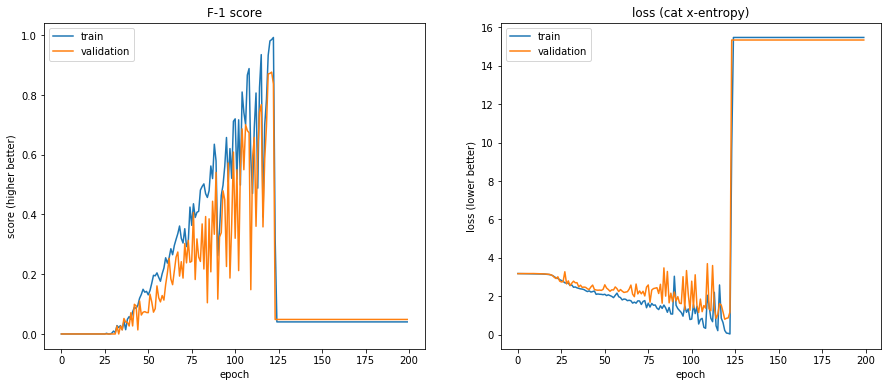

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots (1, 2)

# summarize history for accuracy
axs[0].plot (history.history['fbeta'])
if 'val_fbeta' in history.history:
    axs[0].plot (history.history['val_fbeta'])
axs[0].set (xlabel='epoch', ylabel='score (higher better)', title='F-{} score'.format (PARAM_BETA))
axs[0].legend (['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot (history.history['loss'])
if 'val_loss' in history.history:
    axs[1].plot (history.history['val_loss'])
axs[1].set (xlabel='epoch', ylabel='loss (lower better)', title='loss (cat x-entropy)')
axs[1].legend (['train', 'validation'], loc='upper left')

fig.set_size_inches ((15., 6.), forward=True)
plt.show ()

**discussion**
none

#### reasons / todo

*input data*

(2) A quick look at random spectrograms show kind of chaotic information - as a human being it is hard to tell if there's any structure behind each key-mode pair. This may apply to the CNN too.

Todo: find additional filter techniques / methods to clearly bring out structures for the CNN

_


*model architecture*

Todo: To better understand the insight of the CNN, visualize the filter of the convolutions. May there be enlightenment what kind of architecture works best.

#### compare learning algorithm to benchmarks

[i] below statements can be run without executing the whole notebook

Therefor, go to and execute <a href='#load-learning-algorithm'>load learning algorithm</a>

**TODO** **TODO** **TODO**

**benchmark data - fft**

Juypter Notebook <a href='./00.hlp/fft/fft.ipynb#Benchmark-data'>benchmark data - fft</a>

<a href='./model/model.eval.ipynb'>model.eval.ipynb</a>

## Misc
---

### save learning algorithm

In [38]:
# serialization of model architecture
import os
import time
import pandas as pd

t = time.strftime ("%Y%m%d-%H%M%S", time.gmtime ())

# save model architecture
save_name = os.path.join ('model', t + '_model.arch' + '.yaml')
print ('>>> saving model architecture...', end=' ', flush=True)
yaml_string = model.to_yaml ()
with open (save_name, 'w') as yaml_file:
    yaml_file.write (yaml_string)
print ('done')

# save model weights
save_name = os.path.join ('model', t + '_model.weights' + '.h5')
print ('>>> saving model weights...', end=' ', flush=True)
model.save_weights (save_name)
print ('done')

# save learning history
save_name = os.path.join ('model', t + '_model.hist' + '.csv')
print ('>>> saving model history...', end=' ', flush=True)
hist_df = pd.DataFrame.from_dict (history.history)
hist_df.to_csv (save_name)
print ('done')

# save parameter
save_name = os.path.join ('model', t + '_model.param' + '.txt')
print ('>>> saving model parameter...', end=' ', flush=True)
str_to_write = str ({'seed':PARAM_RND_STATE, 'use_img_std':PARAM_USE_IMG_STD,
                'opt':str (type (opt)), 'lr':PARAM_LR, 'mom':PARAM_MOM, 'loss':str (type (loss)),
                'epochs':PARAM_MAX_EPOCHS, 'batch_size':PARAM_N_BATCH, 'val_split':PARAM_VAL_SPLIT})
with open (save_name, 'w') as str_file:
    str_file.write (str_to_write)
print ('done')

>>> saving model architecture... done
>>> saving model weights... done
>>> saving model history... done
>>> saving model parameter... done


### load learning algorithm

In [39]:
# load model architecture
import os
from keras import models

load_name = os.path.join ('model', '20180908-094455_model.arch.yaml')
print ('>>> loading and compiling model...', end=' ', flush=True)
with open (load_name, 'r') as yaml_file:
    yaml_string = yaml_file.read ()
model = models.model_from_yaml (yaml_string)
model.compile (optimizer=opt, loss=loss, metrics=[fbeta])
print ('done')

# load best weights
print ('>>> loading best weights into model...', end=' ', flush=True)
model.load_weights (os.path.join ('model','20180908-094455_model.weights.b.h5'))
print ('done')

model.summary ()

>>> loading and compiling model... done
>>> loading best weights into model... done
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 1)       0         
_________________________________________________________________
fex.conv2d_1 (Conv2D)        (None, 160, 160, 64)      320       
_________________________________________________________________
fex.maxp_1 (MaxPooling2D)    (None, 80, 80, 64)        0         
_________________________________________________________________
fex.conv2d_2 (Conv2D)        (None, 80, 80, 128)       32896     
_________________________________________________________________
fex.maxp_2 (MaxPooling2D)    (None, 40, 40, 128)       0         
_________________________________________________________________
fex.conv2d_3 (Conv2D)        (None, 40, 40, 256)       131328    
__________________________________________________________

## Obsolete

**drawbacks** (known, unresolvable issues)

(WRONG) *music keys vs CNN key classes*

See <a href='https://www.researchgate.net/publication/228963946_Audio_onset_detection_using_machine_learning_techniques_the_effect_and_applicability_of_key_and_tempo_information'>Chuan, Ching-Hua & Chew, Elaine. (2018). Audio onset detection using machine learning techniques: the effect and applicability of key and tempo information.</a>, p. 18

The spectrograms show a pitch range given by the <a href='https://en.wikipedia.org/wiki/Scientific_pitch_notation#Table_of_note_frequencies'>Scientific Pitch Notation</a>. By that the range of notes goes from $C_{-1}$ = $0_{MIDI}$ up to $G_9$ = $127_{MIDI}$.

Each note can be the tonic of a music key - for example the key 'C major' exists 11 times (ocatve -1 to 9). Thus the information of 128 keys is now squeezed into 24 key classes.

...